In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from tqdm.autonotebook import tqdm
import pickle
from utils.utilities import select_by_date
from utils.strings import FEATURES, CAT_FEATURES, DATE


/home/boada/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [5]:
inspecs = pd.read_csv('./data/inspec_scores.csv', parse_dates=[DATE])

In [8]:
clf_path = 'models/RFmodel.pkl'
with open(clf_path, 'rb') as f:
    model= pickle.load(f)
    
def load_catalogs(start_date, end_date, FEATURES=FEATURES):
    inspecs = pd.read_csv('./data/inspec_scores.csv', parse_dates=[DATE])
    for feat in CAT_FEATURES:
        try:
            new_df = pd.concat([new_df, pd.get_dummies(inspecs[feat])], axis=1)                                                        
        except NameError:                                                                                                              
            new_df = pd.DataFrame(index=inspecs.index)                                                                                 
            new_df = pd.concat([new_df, pd.get_dummies(inspecs[feat])], axis=1)                                                        
    FEATURES_big = FEATURES + new_df.columns.tolist()                                                                                  
    inspecs = pd.concat([inspecs, new_df], axis=1)                                                                                     
                                                                                                                                       
    test = select_by_date(inspecs, start_date, end_date)                                                                               
                                                                                                                                       
    return test, FEATURES_big

In [26]:
START_DATE = '2019-07-01'
END_DATE = '2019-08-31'

df, FEATURES_big = load_catalogs(START_DATE, END_DATE)

In [27]:
pred = model.predict(df[FEATURES_big])
pred_prob = model.predict_proba(df[FEATURES_big])
df['preds'] = pred
df['probs'] = pred_prob[:, 1]

In [28]:
# noticed that some of the restaurants have repeat inspections. 
# we'll remove them to get a better sense of how well we are doing
# on per day basis

df.sort_values(DATE, inplace=True)
df.drop_duplicates('camis', keep='first', inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5196 entries, 14631 to 77689
Columns: 267 entries, camis to probs
dtypes: datetime64[ns](1), float64(12), int64(7), object(11), uint8(236)
memory usage: 2.4+ MB


In [30]:
# only need a few columns

df2 = df[['critical', DATE, 'probs']]

In [31]:
# how many do they inspec each day in our window?

df2 = df[[DATE, 'critical', 'probs', 'camis']]
df3 = df2[DATE].value_counts()
dates = pd.date_range(START_DATE, END_DATE, freq='1D')
df4 = pd.DataFrame()
df4['date'] = dates
inspecs_per_day = df4.merge(df3, left_on='date', right_on=df3.index, how='left')
inspecs_per_day.rename(columns={'inspection_date': 'num_inspec'}, inplace=True)
inspecs_per_day['num_inspec'].replace(np.nan, 0.0, inplace=True)

In [32]:
inspecs_per_day

,date,num_inspec
0,2019-07-01,0.0
1,2019-07-02,156.0
2,2019-07-03,169.0
3,2019-07-04,0.0
4,2019-07-05,72.0
...,...,...
57,2019-08-27,98.0
58,2019-08-28,109.0
59,2019-08-29,118.0
60,2019-08-30,62.0


In [33]:
# ok, the goal is to figure out what day they would have been
# inspected if we used my ordering scheme instead of the City's

df2_prob_sorted = df2.sort_values('probs', ascending=False)
df2_prob_sorted['inspection_date_probs'] = np.nan
# have to reset the index
df2_prob_sorted.reset_index(inplace=True)

num_start = 0
for i, row in inspecs_per_day.iterrows():
    df2_prob_sorted.loc[num_start:num_start+row.num_inspec, 'inspection_date_probs'] = row.date
    num_start += row.num_inspec

In [34]:
df2_prob_sorted[[DATE, 'critical', 'probs', 'camis', 'inspection_date_probs']]

,inspection_date,critical,probs,camis,inspection_date_probs
0,2019-07-16,1,1.00,41651295,2019-07-02 00:00:00
1,2019-07-25,1,1.00,50075089,2019-07-02 00:00:00
2,2019-08-13,1,1.00,50019021,2019-07-02 00:00:00
3,2019-07-17,1,1.00,41696519,2019-07-02 00:00:00
4,2019-07-16,1,1.00,50048546,2019-07-02 00:00:00
...,...,...,...,...,...
5191,2019-07-02,1,0.35,40634607,2019-08-31 00:00:00
5192,2019-08-09,0,0.33,50052651,2019-08-31 00:00:00
5193,2019-08-27,1,0.31,41505017,2019-08-31 00:00:00
5194,2019-08-29,0,0.28,41618756,2019-08-31 00:00:00


In [35]:
# how many day earlier?
df2_prob_sorted['delta_date'] = pd.to_datetime(df2_prob_sorted['inspection_date_probs']) - pd.to_datetime(df2_prob_sorted[DATE])

In [36]:
df2_prob_sorted['inspection_date_probs'] = pd.to_datetime(df2_prob_sorted['inspection_date_probs'])

In [37]:
df2_prob_sorted

,index,inspection_date,critical,probs,camis,inspection_date_probs,delta_date
0,49229,2019-07-16,1,1.00,41651295,2019-07-02,-14 days
1,106967,2019-07-25,1,1.00,50075089,2019-07-02,-23 days
2,73934,2019-08-13,1,1.00,50019021,2019-07-02,-42 days
3,53257,2019-07-17,1,1.00,41696519,2019-07-02,-15 days
4,88081,2019-07-16,1,1.00,50048546,2019-07-02,-14 days
...,...,...,...,...,...,...,...
5191,8770,2019-07-02,1,0.35,40634607,2019-08-31,60 days
5192,90844,2019-08-09,0,0.33,50052651,2019-08-31,22 days
5193,38347,2019-08-27,1,0.31,41505017,2019-08-31,4 days
5194,45635,2019-08-29,0,0.28,41618756,2019-08-31,2 days


In [38]:
cs = df2_prob_sorted.sort_values(DATE).critical.cumsum()
cs2 = df2_prob_sorted.sort_values('inspection_date_probs').critical.cumsum()

<IPython.core.display.Javascript object>


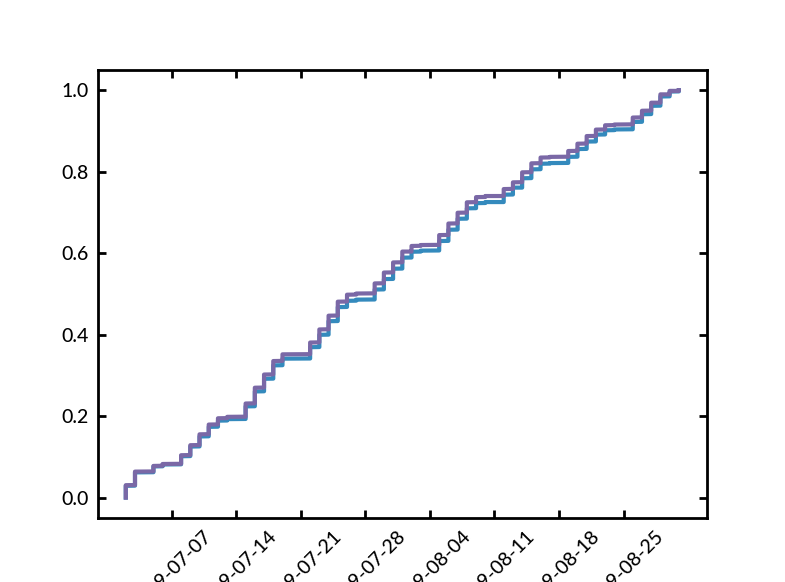

In [42]:
plt.plot(df2_prob_sorted.sort_values(DATE)[DATE].values, cs.values/cs.values[-1], lw=3)
plt.plot(df2_prob_sorted['inspection_date_probs'].values, cs2.values/cs2.values[-1], lw=3)

In [43]:
dates = pd.date_range(START_DATE, END_DATE, freq='1W')
ax = plt.gca()
ax.set_xticks(dates)
plt.xticks(rotation=45)

(array([737247., 737254., 737261., 737268., 737275., 737282., 737289.,
        737296.]), <a list of 8 Text xticklabel objects>)

In [104]:
# plt.savefig('inspection_cumsum.png', bbox='tight')

<IPython.core.display.Javascript object>


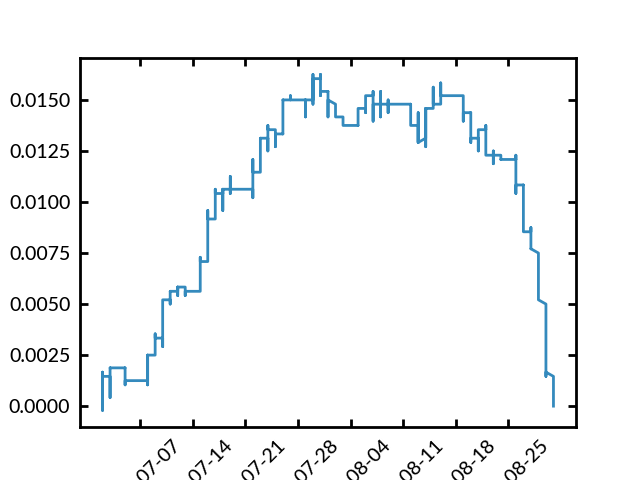

(array([737247., 737254., 737261., 737268., 737275., 737282., 737289.,
        737296.]), <a list of 8 Text xticklabel objects>)

In [44]:
plt.plot(df2[DATE].values, cs2.values/cs2.values[-1] - cs.values/cs.values[-1])
dates = pd.date_range(START_DATE, END_DATE, freq='1W')
ax = plt.gca()
ax.set_xticks(dates)
plt.xticks(rotation=45)

In [50]:
np.mean(cs2.values/cs2.values[-1] - cs.values/cs.values[-1])

0.010484024168397084

In [46]:
df2_prob_sorted[df2_prob_sorted[DATE] < '2019-08-01'].delta_date.mean()

Timedelta('11 days 05:19:03.936791')

In [47]:
df2_prob_sorted[df2_prob_sorted['inspection_date_probs'] < '2019-08-01'].delta_date.mean()

Timedelta('-12 days +14:31:07.399519')

In [48]:
df2_prob_sorted['inspection_date_probs'].values

array(['2019-07-02T00:00:00.000000000', '2019-07-02T00:00:00.000000000',
       '2019-07-02T00:00:00.000000000', ...,
       '2019-08-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2019-08-31T00:00:00.000000000'], dtype='datetime64[ns]')